In [48]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

file = "./SAS_18_03/Pranav/Random/DigiLock-LockData.txt"

In [49]:
df = pd.read_csv(file, sep="\t")
df

,SC110 out [V],Main in [V],SC110 out [V].1,LI out [a.u.]
0,7.6272,-0.082673,7.6272,-3.0
1,7.6278,-0.082916,7.6278,-2.0
2,7.6285,-0.082673,7.6285,2.0
3,7.6291,-0.082673,7.6291,-5.0
4,7.6298,-0.082916,7.6298,-6.0
...,...,...,...,...
995,8.2911,-0.075878,8.2911,22.0
996,8.2918,-0.076364,8.2918,23.0
997,8.2924,-0.076121,8.2924,18.0
998,8.2932,-0.076121,8.2932,19.0


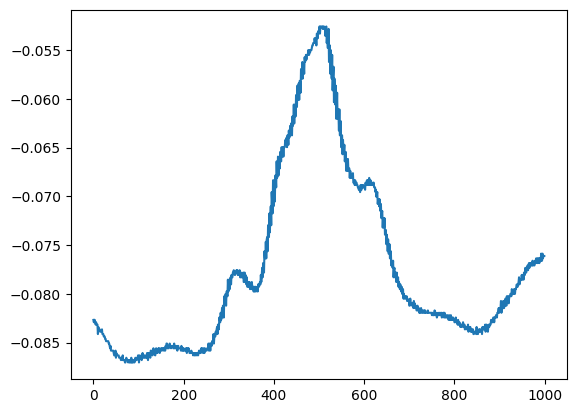

In [50]:
plt.plot(df["Main in [V]"])

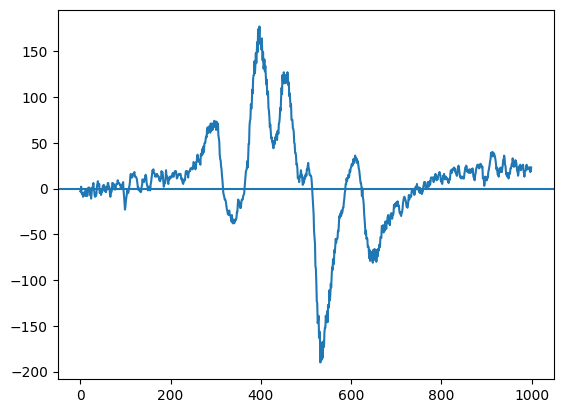

In [52]:
plt.axhline()
plt.plot(df["LI out [a.u.]"])
plt.show()

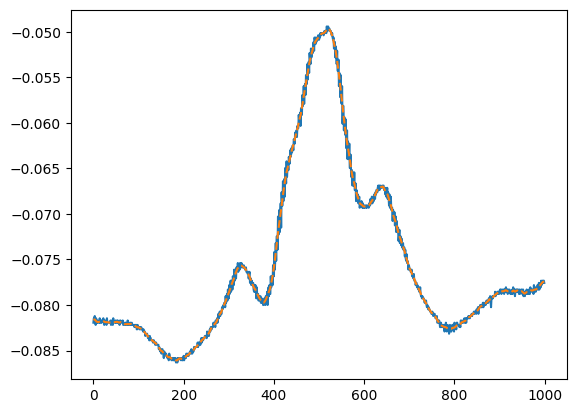

In [6]:
from scipy.ndimage import gaussian_filter1d
# experiment 1: apply smoothing (bas dekhne ke liye)

# gaussian filter
y = df["Main in [V]"]
y_smooth = gaussian_filter1d(y, sigma=2)
plt.plot(y)
plt.plot(y_smooth, "--")

In [ ]:
def gaussian(x, mu, sig):
    return (
        1.0 / (np.sqrt(2.0 * np.pi) * sig) * np.exp(-np.power((x - mu) / sig, 2.0) / 2)
    )

5


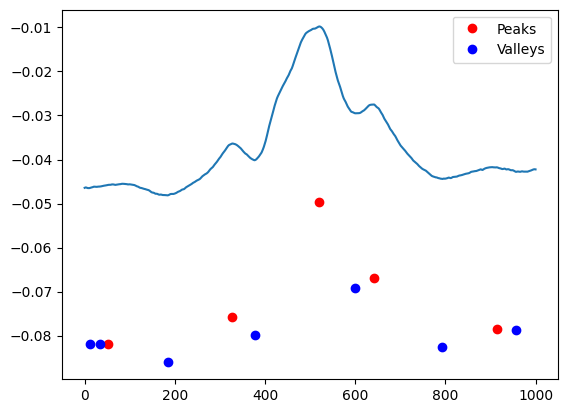

In [ ]:
from scipy.signal import find_peaks

peaks, _ = find_peaks(y_smooth, width=10)
valleys, _ = find_peaks(-y_smooth, width=7)
print(peaks.__len__())

x = np.linspace(0, 1000, 1000)
plt.plot(x, y_smooth - y_sub)
plt.plot(x[peaks], y_smooth[peaks], "ro", label="Peaks")
plt.plot(x[valleys], y_smooth[valleys], "bo", label="Valleys")

plt.legend()

KeyError: 'Main in [V]'

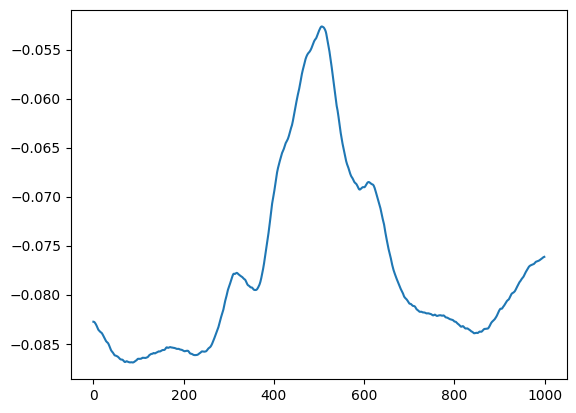

In [53]:
n = 30
data = np.zeros((n, 1000))
peaks = np.zeros((n, 3))
for i in range(1, 30):
    file = "./SAS_18_03/Pranav/Random/DigiLock-LockData" + str(i) + ".txt"
    df = pd.read_csv(file, sep="\t")
    y = df["Main in [V]"]
    y_smooth = gaussian_filter1d(y, sigma=2)
    plt.plot(y_smooth)